In [1]:
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "vscode"
from pyspark.sql import SparkSession
from pyspark.sql.functions import split, explode, col, regexp_replace, transform, isnan

spark = SparkSession.builder.appName("LightcastCleanedData").getOrCreate()

# 重新加载处理后的数据
df_cleaned = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").csv("data/lightcast_cleaned.csv")

# 查看数据结构和样本
df_cleaned.show(5)

your 131072x1 screen size is bogus. expect trouble
25/04/20 19:32:25 WARN Utils: Your hostname, DESKTOP-AEE21PF resolves to a loopback address: 127.0.1.1; using 192.168.167.208 instead (on interface eth0)
25/04/20 19:32:25 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/20 19:32:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/20 19:32:32 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-------------------+----------------------+----------+----------+----------+--------+------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+---------

In [2]:
# 转换为 Pandas DataFrame，只取 BODY 列
body_df = df_cleaned.select("BODY").dropna().toPandas()

# 清理文本（可选）
body_df["BODY"] = body_df["BODY"].str.replace(r'\n|\r', ' ', regex=True)

# TF-IDF 提取
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = tfidf_vectorizer.fit_transform(body_df["BODY"])

# 查看特征词
print(tfidf_vectorizer.get_feature_names_out()[:20])


['00' '000' '10' '100' '11' '12' '15' '20' '200' '2024' '24' '25' '30'
 '40' '401' '401k' '4hana' '50' '500' 'abilities']


生成第 0 类的词云...


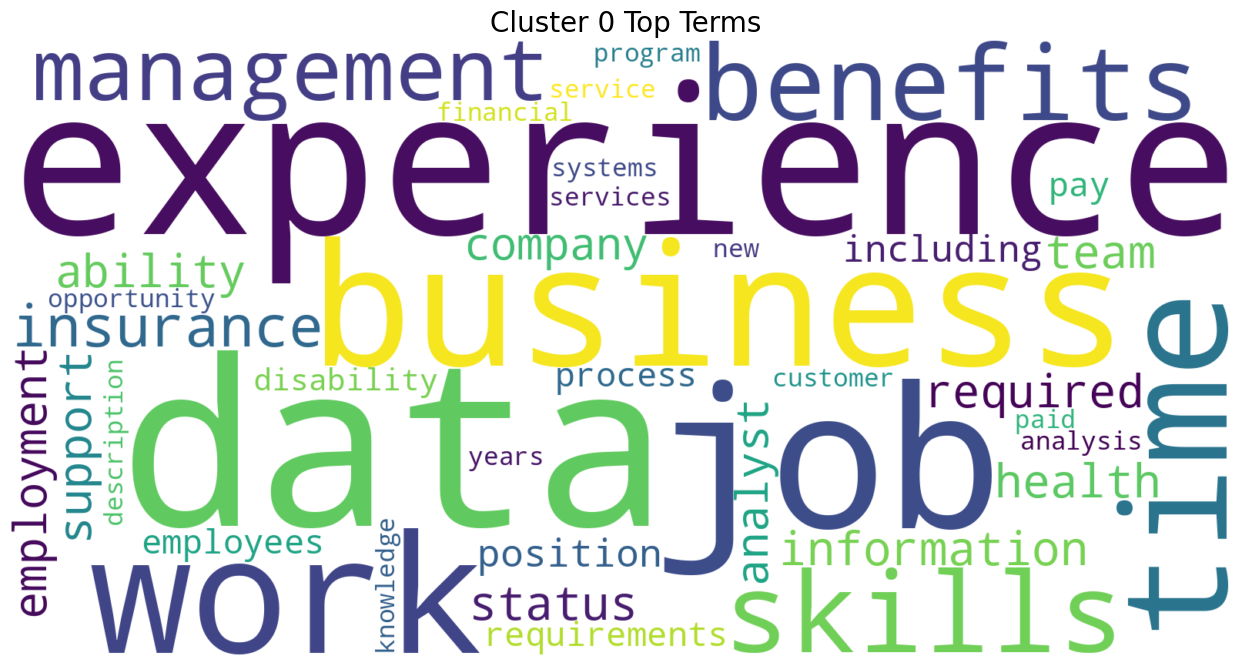

生成第 1 类的词云...


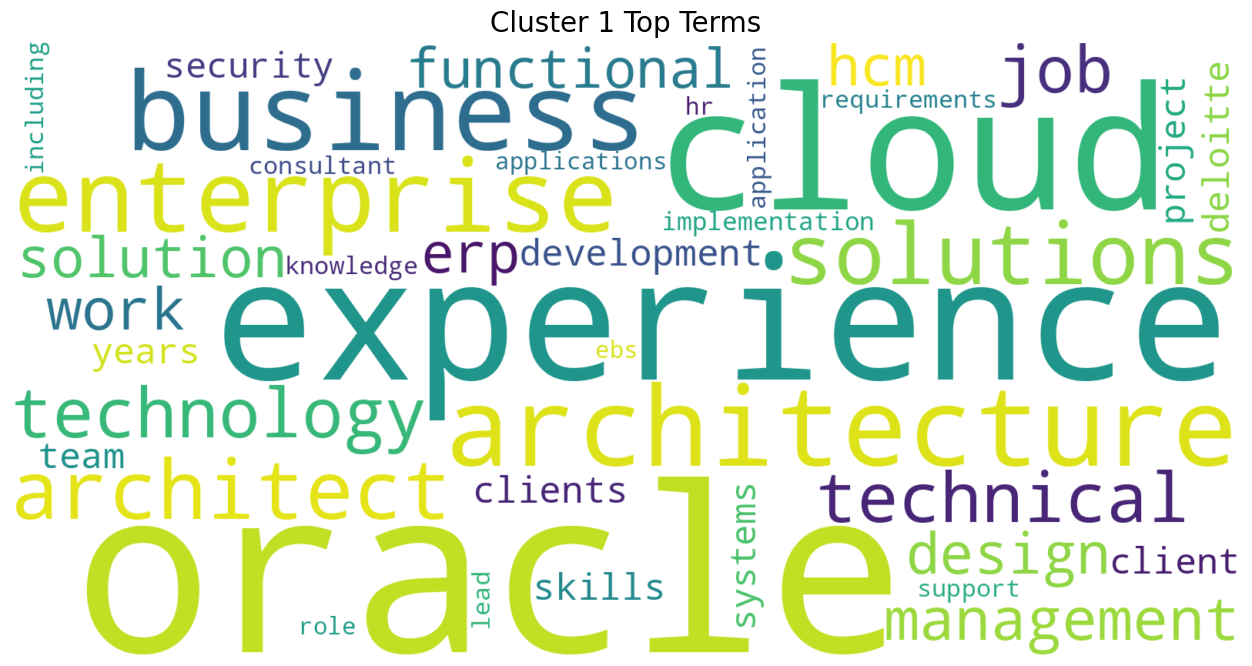

生成第 2 类的词云...


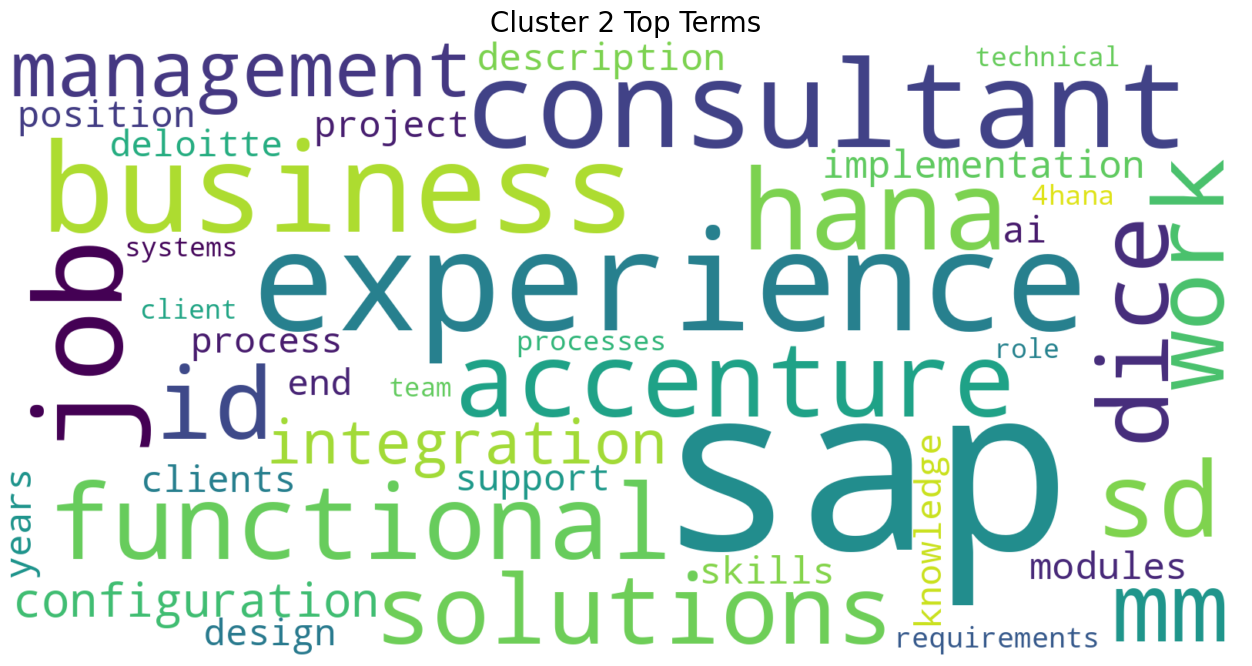

生成第 3 类的词云...


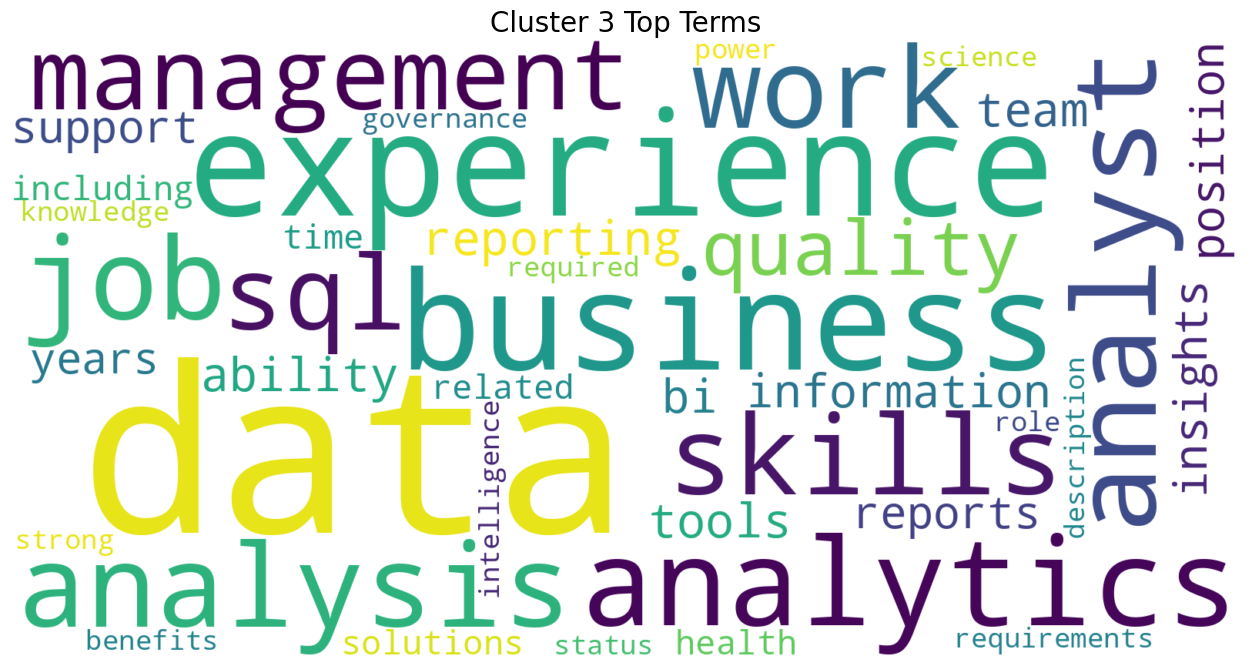

In [3]:
from sklearn.cluster import KMeans

# 聚成 k 类（你可以调整 n_clusters）
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_tfidf)

# 把聚类结果加到原 DataFrame 中
body_df["cluster"] = clusters

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 获取词汇表
terms = tfidf_vectorizer.get_feature_names_out()

# 获取每个聚类中心的前关键词
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

import os

# 创建目录（如果不存在）
output_dir = "images/wordcloud"
os.makedirs(output_dir, exist_ok=True)

for i in range(k):
    print(f"生成第 {i} 类的词云...")

    top_terms = [terms[ind] for ind in order_centroids[i, :40]]
    weights = {term: kmeans.cluster_centers_[i][terms.tolist().index(term)] for term in top_terms}

    wordcloud = WordCloud(
        background_color='white',
        width=1600,
        height=800,
        max_font_size=300,
        prefer_horizontal=0.9
    ).generate_from_frequencies(weights)

    plt.figure(figsize=(16, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Cluster {i} Top Terms", fontsize=20)

    # 保存图像到指定目录
    output_path = os.path.join(output_dir, f"cluster_{i}_wordcloud.png")
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()




In [22]:
import plotly.express as px

fig = px.histogram(body_df, x="cluster", nbins=k, title="Distribution of jobs by theme (cluster)")
fig.write_html("./images/jobs_by_theme.html")
fig.show()


🔍 Naive Bayes :
              precision    recall  f1-score   support

           0       0.82      0.87      0.85      5514
           1       0.91      0.91      0.91      2886
           2       0.90      0.90      0.90      1947
           3       0.87      0.80      0.83      4149

    accuracy                           0.86     14496
   macro avg       0.87      0.87      0.87     14496
weighted avg       0.86      0.86      0.86     14496


🔍 SVM :
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      5514
           1       0.98      0.98      0.98      2886
           2       0.98      0.99      0.99      1947
           3       0.98      0.98      0.98      4149

    accuracy                           0.98     14496
   macro avg       0.98      0.98      0.98     14496
weighted avg       0.98      0.98      0.98     14496



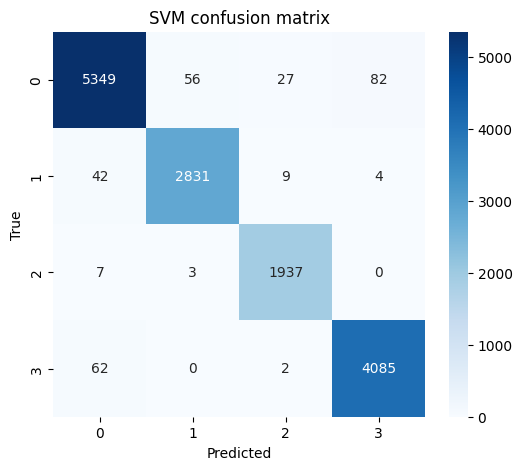

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 使用 cluster 作为分类目标
y = body_df["cluster"]

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 1️⃣ 训练 Naive Bayes 分类器
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb = nb_model.predict(X_test)

# 2️⃣ 训练 SVM 分类器
svm_model = LinearSVC()
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# 评估：Naive Bayes
print("\n🔍 Naive Bayes :")
print(classification_report(y_test, y_pred_nb))

# 评估：SVM
print("\n🔍 SVM :")
print(classification_report(y_test, y_pred_svm))

# 混淆矩阵（SVM）
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(k), yticklabels=range(k))
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("SVM confusion matrix")
plt.savefig("images/SVM_confusion_matrix.png", dpi=300, bbox_inches='tight')  
plt.show()


In [24]:
import numpy as np
import pandas as pd
import plotly.express as px

# 提取 TF-IDF 的词汇和矩阵
terms = tfidf_vectorizer.get_feature_names_out()
tfidf_matrix = X_tfidf.toarray()

# 🔹 方式一：按词频排序
term_frequencies = tfidf_matrix.sum(axis=0)
freq_df = pd.DataFrame({'term': terms, 'frequency': term_frequencies})
freq_df = freq_df.sort_values(by='frequency', ascending=False).head(30)

# 可视化：词频
fig1 = px.bar(freq_df, x='term', y='frequency', title="📈 Top 30 high-frequency words (by word frequency)", text_auto='.2s')
fig1.update_layout(xaxis_tickangle=-45)
fig1.write_html("./images/Top30_high_frequency.html")
fig1.show()

# 🔹 方式二：按 TF-IDF 均值排序（更偏向“重要性”）
tfidf_mean = tfidf_matrix.mean(axis=0)
tfidf_df = pd.DataFrame({'term': terms, 'importance': tfidf_mean})
tfidf_df = tfidf_df.sort_values(by='importance', ascending=False).head(30)

# 可视化：TF-IDF
fig2 = px.bar(tfidf_df, x='term', y='importance', title="🔥 前 30 高权重词（按 TF-IDF）", text_auto='.2s')
fig2.update_layout(xaxis_tickangle=-45)
fig2.show()
